In [1]:
from scipy import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("X_train.csv")

In [3]:
answers = pd.read_csv("y_train.csv")

In [4]:
data = (pd.merge(data ,answers, on = "Unnamed: 0"))
data['age'] = (data['age'] - data['age'].mean(axis = 0))/data['age'].std(axis = 0)

In [5]:
data = data.drop( ["Unnamed: 0"], axis = 1)

In [6]:
from torch.utils.data import Dataset

In [7]:
class EcgBaseDataset(Dataset):
    def __init__(self, data):
        self.data = data.values
        self._process_dataset()
        
        
    def _get_row(self, row):
        return [row[i : i + 5000] for i in range(2, 55003, 5000)]
        
    def _process_dataset(self):
        self.signals = np.apply_along_axis(lambda x: self._get_row(x), 1, self.data)

    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return len(self.data)
    

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        """
        return self.signals[idx], self.data[idx][-1]

In [8]:
dataset = EcgBaseDataset(data)

In [9]:
dataset[0][0].shape

(12, 5000)

In [10]:
leds = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5',
       'v6']

In [11]:
def plot_ecg(ecg, label):
    f = plt.figure(figsize=(15, 10))
    f.suptitle("Ecg "+ str(label))
    gs = f.add_gridspec(4,3)
    for led in range(12):
        ax = f.add_subplot(gs[led//3,led%3])
        ax.plot(ecg[led])
        ax.set_title(leds[led])

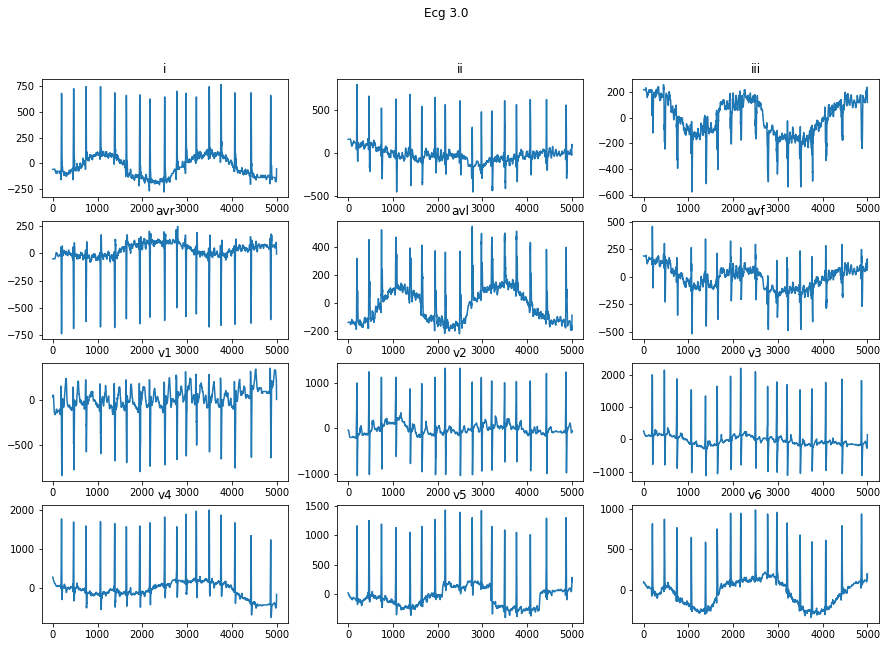

In [12]:
plot_ecg(*dataset[0])

In [13]:
def erosion(signal, element):
    signal_len = len(signal)
    element_len = len(element)
    result = np.zeros((signal_len,))
    window =  (element_len - 1)//2
    for n in range(signal_len):
        left_window = min(n, window)
        right_window = min(signal_len-n-1, window)
        try:
            result[n] = np.min(signal[n-left_window:n+right_window+1] - element[window-left_window:window+right_window+1])
        except:
            print(n, left_window, right_window, window)
    return result
        

In [14]:
def dilation(signal, element):
    signal_len = len(signal)
    element_len = len(element)
    result = np.zeros((signal_len,))
    window =  (element_len - 1)//2
    for n in range(signal_len):
        left_window = min(n, window)
        right_window = min(signal_len-n-1, window)
        try:
            result[n] = np.max(signal[n-left_window:n+right_window+1][::-1] - element[window-left_window:window+right_window+1])
        except:
            print(n, left_window, right_window, window)
    return result
        

In [15]:
signal_i_0 = dataset[0][0][0]

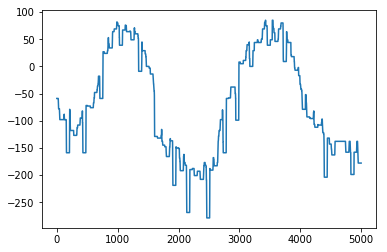

In [16]:
plt.plot(erosion(signal_i_0, np.zeros(50)))

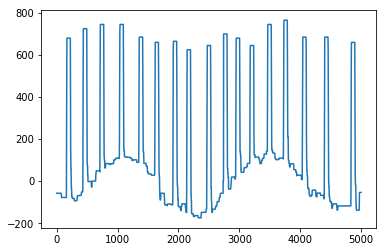

In [17]:
plt.plot(dilation(signal_i_0, np.zeros(55)))

In [18]:
def opening(signal, element):
    return dilation(erosion(signal, element), element)

In [19]:
def closing(signal, element):
    return erosion(dilation(signal, element), element)

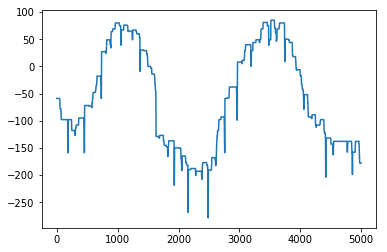

In [20]:
plt.plot(opening(signal_i_0, np.zeros(55)))

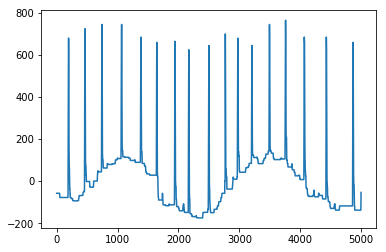

In [21]:
plt.plot(closing(signal_i_0, np.zeros(55)))

In [43]:
def step(signal, element1, element2):
    left = opening(closing(signal, element1), element2)
    right = closing(opening(signal, element1), element2)
    return (left+right)/2

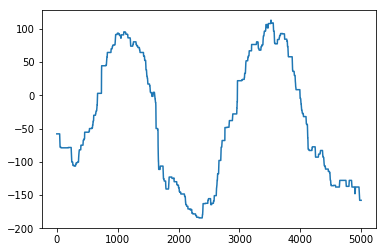

In [44]:
plt.plot(step(signal_i_0, np.zeros(45), np.zeros(45)))

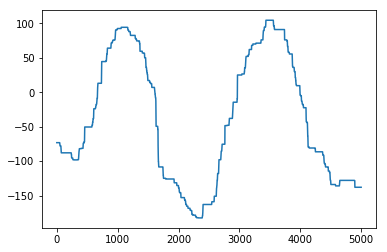

In [45]:
plt.plot(step(step(signal_i_0, np.zeros(55), np.zeros(110)), np.zeros(55), np.zeros(110)))

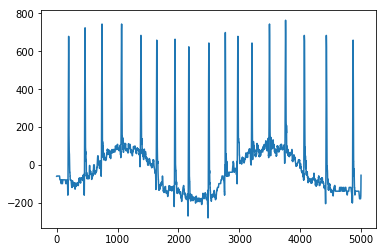

In [46]:
plt.plot(signal_i_0)

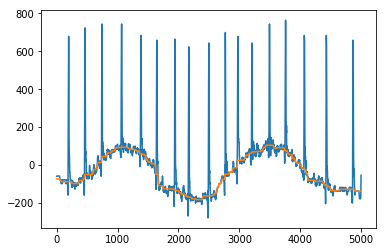

In [47]:
plt.plot(signal_i_0)
plt.plot(step(step(signal_i_0, np.zeros(55), np.zeros(110)), np.zeros(55), np.zeros(110)))

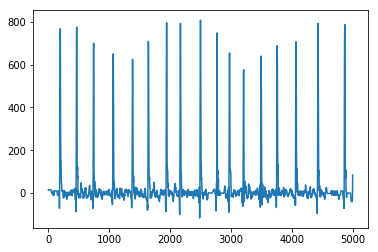

In [48]:
plt.plot(signal_i_0 - step(step(signal_i_0, np.zeros(55), np.zeros(110)), np.zeros(55), np.zeros(110)))

In [49]:
def bandpass(data, fs, fc_low=5, fc_high=20):
        """
        Apply a bandpass filter onto the signal, and save the filtered
        signal.
        """
    

        b, a = signal.butter(2, [float(fc_low) * 2 / fs,
                                 float(fc_high) * 2 / fs], 'pass')
        return signal.filtfilt(b, a, data,
                                     axis=0)

In [52]:
def bandstop(data, fs, fc_stop = 60, fc_window=5):
        """
        Apply a bandpass filter onto the signal, and save the filtered
        signal.
        """
    

        b, a = signal.butter(2, [float(fc_stop - fc_window) * 2 / fs,
                                 float(fc_stop + fc_window) * 2 / fs], 'bandstop')
        return signal.filtfilt(b, a, data,
                                     axis=0)

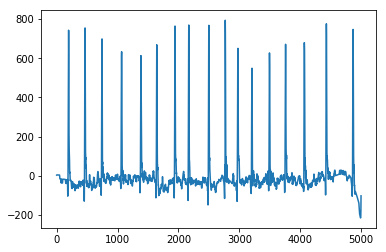

In [57]:
plt.plot(bandpass(signal_i_0, 500, 0.5, 150))

In [58]:
def frequenncy_filter(signal, params):
    fs = params.get('fs', 500)
    stop = params.get('stop', 50)
    window = params.get('window', 5)
    low = params.get('low', 0.5)
    high = params.get('high', 150)
    return bandstop(bandpass(signal, fs, low, high), fs, stop, window)

In [59]:
def chu_filter(signal, params):
    noise = params.get('noise', np.array([0,1, 9,1, 0]))
    se1 = params.get("se1", np.zeros(55))
    se2 = params.get('se2', np.zeros(110))
    after_noize_removal = step(signal, noise, noise)
    return after_noize_removal - step(after_noize_removal, se1, se2)

In [60]:
np.random.randint(100)

22

In [71]:
def try_filter(params_frequenncy_filter, params_chu, signal_len):
    f = plt.figure(figsize=(15, 20))
    gs = f.add_gridspec(4,3)
    for n in range(4):
        cut_point = np.random.randint(5000-signal_len[n]-1)
        record_number = np.random.randint(len(dataset))
        led = np.random.randint(12)
        ecg = dataset[record_number][0][led]
        ax1 = f.add_subplot(gs[n, 0])
        ax1.plot(ecg[cut_point:cut_point+signal_len[n]+1])
        ax1.set_title("ECG #{}, led {}".format(record_number, leds[led]))
        ax1.set_xlabel('time')
        ax1.set_ylabel('mV')
        ax2 = f.add_subplot(gs[n, 1])
        ax2.plot(frequenncy_filter(ecg, params_frequenncy_filter)[cut_point:cut_point+signal_len[n]+1])
        ax2.set_title("Frequency filter #{}, led {}".format(record_number, leds[led]))
        ax2.set_xlabel('time')
        ax2.set_ylabel('mV')
        ax3 = f.add_subplot(gs[n, 2])
        ax3.plot(chu_filter(ecg, params_chu)[cut_point:cut_point+signal_len[n]+1])
        ax3.set_title("Chu filter #{}, led {}".format(record_number, leds[led]))
        ax3.set_xlabel('time')
        ax3.set_ylabel('mV')

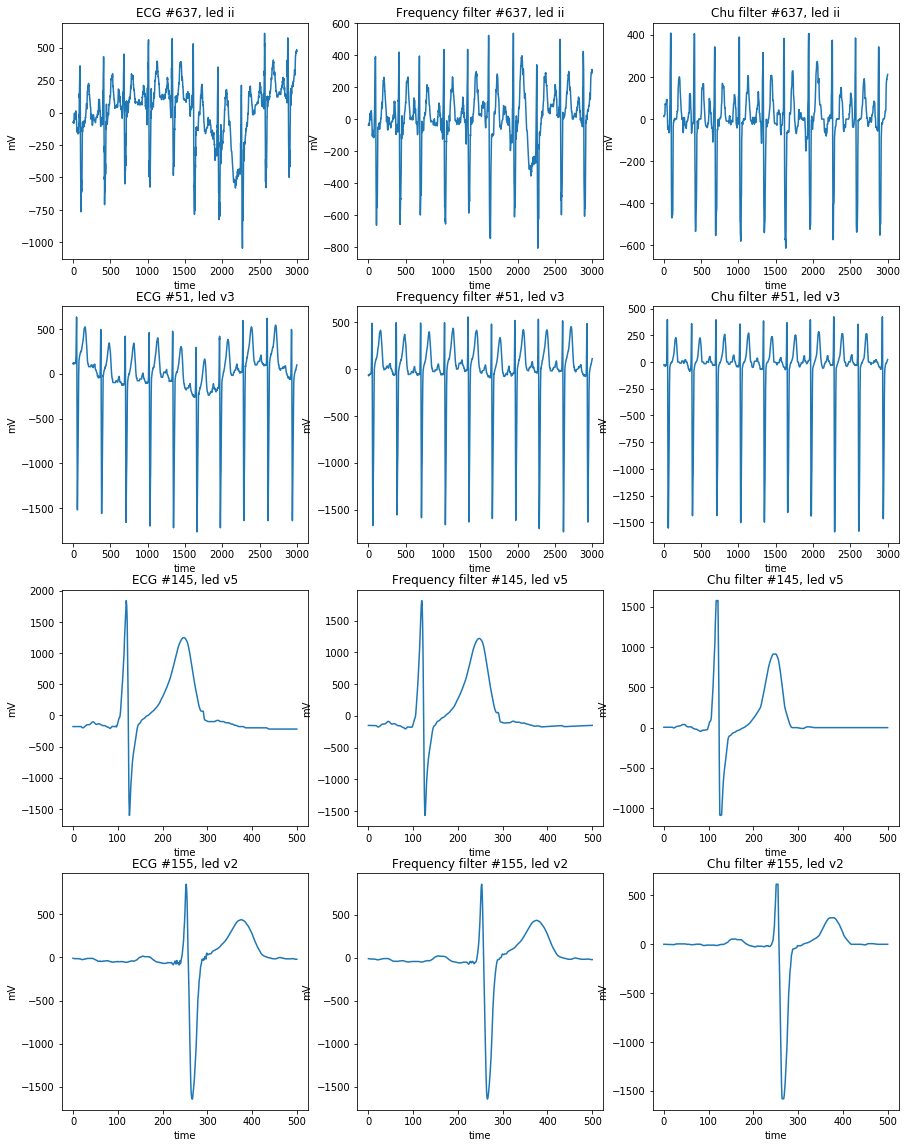

In [127]:
try_filter({'low':0.5, 'high':100}, {'noise':np.array([0, 1,5,1, 0])}, [3000, 3000, 500, 500])

In [36]:
"ECG {}, led {}".format(4, 'i')

'ECG 4, led i'

In [37]:
signal_noised = dataset[561][0][4]

In [38]:
b, a = signal.iirnotch(0.1, 0.01)

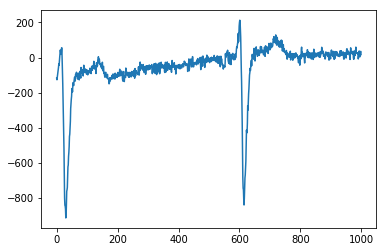

In [39]:
plt.plot(bandstop(signal_noised, 500, 40, 60)[:1000])

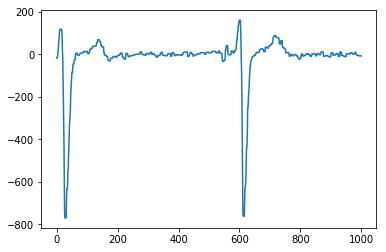

In [40]:
plt.plot( chu_filter(signal_noised - chu_filter(signal_noised,{'se1':np.zeros(5), 'se2':np.zeros(4)}), {})[:1000])

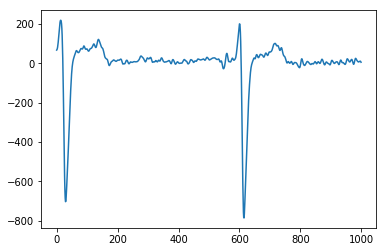

In [41]:
plt.plot(bandpass_filter(signal_noised[:1000], {'high':40}))

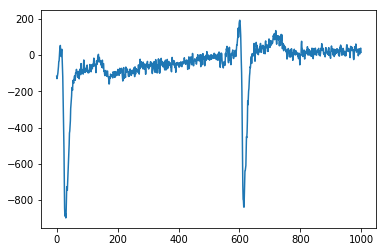

In [42]:
plt.plot(signal_noised[:1000])